<h1>Testing MEGApy</h1>

<h3>Importing ROOTpy and other libs. Defining input files</h3>

In [847]:
import ROOT as M
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from astropy.stats import bayesian_blocks
import scipy.optimize as op


# Load MEGAlib into ROOT
M.gSystem.Load("$(MEGALIB)/lib/libMEGAlib.so")

# Initialize MEGAlib
G = M.MGlobal()
G.Initialize()

# We are good to go ...

#GeometryName = "$(MEGALIB)/resource/examples/geomega/special/Max.geo.setup"
GeometryName = "/Users/thomassiegert/MEGAlib/massmodel/trunk/COSI.DetectorHead.geo.setup" # change accordingly
FileName = "/Users/thomassiegert/data/grb_full_merge.tra"

"""
# Load geometry:
Geometry = M.MDGeometryQuest()
if Geometry.ScanSetupFile(M.MString(GeometryName)) == True:
  print("Geometry " + GeometryName + " loaded!")
else:
  print("Unable to load geometry " + GeometryName + " - Aborting!")
  quit()
"""

'\n# Load geometry:\nGeometry = M.MDGeometryQuest()\nif Geometry.ScanSetupFile(M.MString(GeometryName)) == True:\n  print("Geometry " + GeometryName + " loaded!")\nelse:\n  print("Unable to load geometry " + GeometryName + " - Aborting!")\n  quit()\n'

<h3>Open COSI data TRA file</h3>

In [811]:
Reader = M.MFileEventsTra()
if Reader.Open(M.MString(FileName)) == False:
  print("Unable to open file " + FileName + ". Aborting!")
  quit()

<h3>Define values to read in, convert to numpy arrays</h3>

In [812]:
t1 = time.time()
erg = []
tt = []
et = []

while True:
  Event = Reader.GetNextEvent()
  if not Event:
    break
  erg.append(Event.Ei())
  tt.append(Event.GetTime().GetAsSeconds())
  et.append(Event.GetEventType())
    
erg = np.array(erg)
tt = np.array(tt)
et = np.array(et)

t2 = time.time() - t1
print("time elapsed: ",t2)

time elapsed:  22.183594942092896


<h3>Build spectrum rom time-tagged events</h3>

Text(0, 0.5, 'Counts')

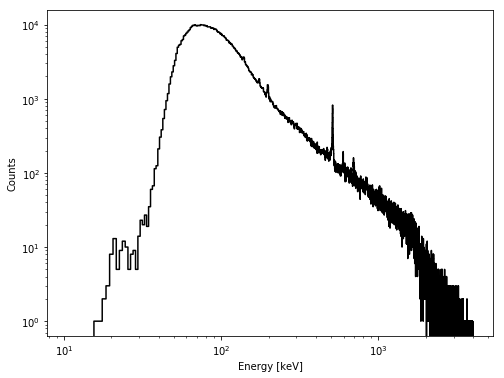

In [848]:
binsize = 1.0
emin = 10
emax = 4001
bins = np.arange(emin,emax,binsize)
tmp = np.histogram(erg,bins=bins)
ee = tmp[1][0:-1] + binsize / 2.
nn = tmp[0]
plt.figure(figsize=(8,6))
plt.step(ee,nn,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')

Total number of events, and useful events:

In [849]:
print(len(erg),len(erg[erg > 10]))

984921 928582


<h3>Get time information</h3>

In [815]:
t_arr = tt - tt[0]
print("First event in data set: ",tt[0])
print("Last photon in data set: ",tt[-1])
print("offset revomed first (should be 0.0): ",t_arr[0])
print("offset removed last: ",t_arr[-1])
timespan = t_arr[-1] - t_arr[0]
print("timespan of data set: ",timespan)

First event in data set:  1464591377.0797627
Last photon in data set:  1464592174.0956452
offset revomed first (should be 0.0):  0.0
offset removed last:  797.0158824920654
timespan of data set:  797.0158824920654


<h3>Build binned light curve and define GRB time and BG window</h3>

In [816]:
tbin_size = 1.0
tbins = np.arange(0,timespan+1,tbin_size)
lc = np.histogram(tt,bins=tbins+tt[0])
ttime = lc[1][0:-1] + tbin_size / 2.
counts = lc[0]
T0 = 1464591827
T0_dt = 20.
T00 = T0 - ttime[0]
hw = 50.

Times outside define GRB window

In [817]:
notgrb = np.where((ttime <= T0-hw) | (ttime >= T0+T0_dt+hw))

<h3>Make light curve plot</h3>

Text(0, 0.5, 'Counts in 1 s')

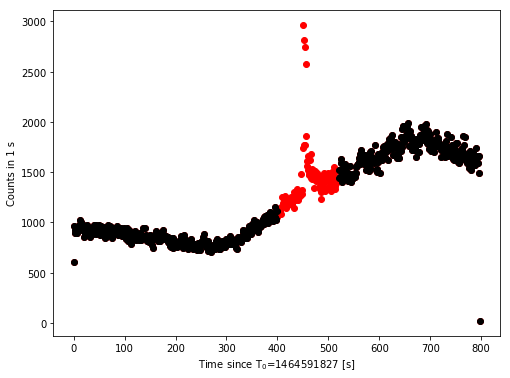

In [818]:
ttime -= ttime[0]
plt.figure(figsize=(8,6))
plt.plot(ttime,counts,'ro')
plt.plot(ttime[notgrb],counts[notgrb],'ko')
plt.xlabel("Time since T$_0$="+str(T0)+" [s]")
plt.ylabel("Counts in 1 s")

<h3>Selections on time, energy, and event type</h3>

In [819]:
t_arr_select  = t_arr[(erg > emin) & (tt > T0-hw) & (tt < T0+hw+T0_dt)]
e_arr_select  = erg[(erg > emin)   & (tt > T0-hw) & (tt < T0+hw+T0_dt)]
et_arr_select = et[(erg > emin)    & (tt > T0-hw) & (tt < T0+hw+T0_dt)]
#redefine light curve
tbins = np.arange(0,timespan+1,tbin_size)
lc = np.histogram(t_arr_select,bins=tbins)
time = lc[1][0:-1] + tbin_size/2.
counts = lc[0]
print("GRB T0 after offset: ",T00)

GRB T0 after offset:  449.42023730278015


<h3>Define background before and after burst and simple subtract for signal spectrum</h3>

In [823]:
# event type 4 == photo effect

bg1_ph = e_arr_select[(t_arr_select > T00-hw)    & (t_arr_select < T00)          & (et_arr_select == 4)]
bg2_ph = e_arr_select[(t_arr_select > T00+T0_dt) & (t_arr_select < T00+T0_dt+hw) & (et_arr_select == 4)]
sig_ph = e_arr_select[(t_arr_select > T00)       & (t_arr_select < T00+T0_dt)    & (et_arr_select == 4)]

dts2 = [hw,hw,T0_dt]

e_bins = 10**np.arange(np.log10(emin),np.log10(emax),0.05)
sig_ph_hist = np.histogram(sig_ph,bins=e_bins)
e2 = (e_bins[1:] + e_bins[0:-1])/2.
e2_err = (e_bins[1:] - e_bins[0:-1])/2.
bg1_ph_hist = np.histogram(bg1_ph,bins=e_bins)
bg2_ph_hist = np.histogram(bg2_ph,bins=e_bins)
bg_ph = (bg1_ph_hist[0]+bg2_ph_hist[0])/(dts2[0]+dts2[1])
bg_ph_err = np.sqrt(bg1_ph_hist[0]+bg2_ph_hist[0])/(dts2[0]+dts2[1])
spbg_ph = sig_ph_hist[0]/(T0_dt)
spbg_ph_err = np.sqrt(sig_ph_hist[0])/(T0_dt)
signal_ph = spbg_ph-bg_ph
signal_ph_err = np.sqrt(bg_ph_err**2 + spbg_ph_err**2)

In [824]:
# event type 0 == compton effect

bg1_ce = e_arr_select[(t_arr_select > T00-hw)    & (t_arr_select < T00)          & (et_arr_select == 0)]
bg2_ce = e_arr_select[(t_arr_select > T00+T0_dt) & (t_arr_select < T00+T0_dt+hw) & (et_arr_select == 0)]
sig_ce = e_arr_select[(t_arr_select > T00)       & (t_arr_select < T00+T0_dt)    & (et_arr_select == 0)]

dts2 = [hw,hw,T0_dt]

e_bins = 10**np.arange(np.log10(emin),np.log10(emax),0.05)
sig_ce_hist = np.histogram(sig_ce,bins=e_bins)
e2 = (e_bins[1:] + e_bins[0:-1])/2.
e2_err = (e_bins[1:] - e_bins[0:-1])/2.
bg1_ce_hist = np.histogram(bg1_ce,bins=e_bins)
bg2_ce_hist = np.histogram(bg2_ce,bins=e_bins)
bg_ce = (bg1_ce_hist[0]+bg2_ce_hist[0])/(dts2[0]+dts2[1])
bg_ce_err = np.sqrt(bg1_ce_hist[0]+bg2_ce_hist[0])/(dts2[0]+dts2[1])
spbg_ce = sig_ce_hist[0]/(T0_dt)
spbg_ce_err = np.sqrt(sig_ce_hist[0])/(T0_dt)
signal_ce = spbg_ce-bg_ce
signal_ce_err = np.sqrt(bg_ce_err**2 + spbg_ce_err**2)

<h3>Plot resulting count rate spectra for PH and CE</h3>

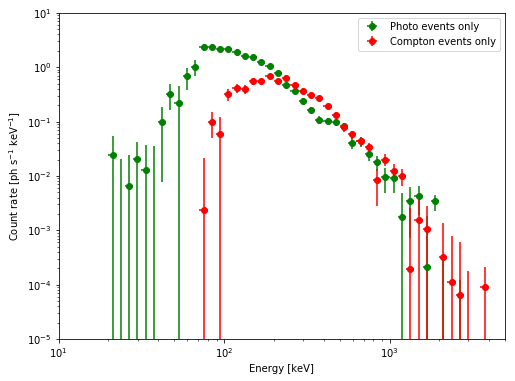

In [825]:
plt.figure(figsize=(8,6))
plt.errorbar(e2,signal_ph/(2*e2_err),xerr=e2_err,yerr=signal_ph_err/(2*e2_err),color='green',fmt='o',label='Photo events only')
plt.errorbar(e2,signal_ce/(2*e2_err),xerr=e2_err,yerr=signal_ce_err/(2*e2_err),color='red',fmt='o',label='Compton events only')

plt.xlim(10,5000)
plt.ylim(1e-5,1e1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Count rate [ph s$^{-1}$ keV$^{-1}$]')
plt.xlabel('Energy [keV]')
plt.legend()

Total photo events, compton events

In [826]:
print(len(sig_ph),len(sig_ce))

26827 7853


<h3>Fitting a phenomelogical model (not knowing the effective area!)</h3>
Comparison values to: <a href=http://www.mpe.mpg.de/~jcg/grb160530A.html>http://www.mpe.mpg.de/~jcg/grb160530A.html</a>

Defining a model like dN/dE ~ (E^alpha)*exp(-E*(2+alpha)/Ep)<br>
    and chi2-fitting ...

In [827]:
def cutoffpl(E,K,alpha,Ep):
    return K*E**alpha*np.exp(-E*(2+alpha)/Ep)

In [828]:
def lnlike(theta, E, F, F_err):
    K, alpha, Ep = theta
    model = cutoffpl(E,K,alpha,Ep)
    return -0.5*(np.sum(( (F - model) / F_err)**2))

Definition of arrays, removing zeros (leads to nans and infs in derivatives); PH case

In [829]:
F_ph     = signal_ph/(2*e2_err)
idx = (F_ph != 0) & (e2 >= 100)
F_ph = F_ph[idx]
F_ph_err = signal_ph_err/(2*e2_err)
F_ph_err = F_ph_err[idx]
E_ph     = e2[idx]
E_ph_err = e2_err[idx]

Starting values

In [830]:
K0 = 1e-5
alpha0 = 4.0
Ep0 = 500.

In [831]:
popt, pcov = op.curve_fit(cutoffpl, E_ph, F_ph, sigma=F_ph_err, p0=[K0,alpha0,Ep0])

Fitting values and uncertainties from covariance matrix

In [832]:
fit_p_ph = popt
fit_e_ph = np.sqrt(np.diag(pcov))
print(fit_p_ph)
print(fit_e_ph)

[ 1.11671002e+04 -1.73220087e+00  1.14347849e+02]
[1.21650655e+04 2.37446900e-01 6.51997421e+01]


Definition of arrays, removing zeros (leads to nans and infs in derivatives); CE case

In [833]:
F_ce     = signal_ce/(2*e2_err)
idx = (F_ce != 0) & (e2 >= 100)
F_ce = F_ce[idx]
F_ce_err = signal_ce_err/(2*e2_err)
F_ce_err = F_ce_err[idx]
E_ce     = e2[idx]
E_ce_err = e2_err[idx]

In [834]:
popt, pcov = op.curve_fit(cutoffpl, E_ce, F_ce, sigma=F_ce_err, p0=[K0,alpha0,Ep0])

Fitting values and uncertainties from covariance matrix

In [835]:
fit_p_ce = popt
fit_e_ce = np.sqrt(np.diag(pcov))
print(fit_p_ce)
print(fit_e_ce)

[2.36087611e-04 1.85606229e+00 3.66431258e+02]
[3.96446709e-04 3.60640225e-01 1.25561651e+01]


<h3>Plot PH and CE data in EF_E and model fits</h3>

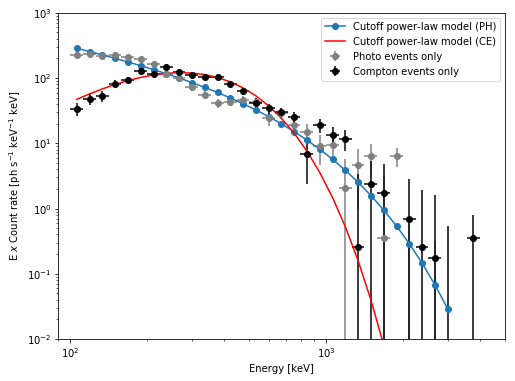

In [836]:
plt.figure(figsize=(8,6))
plt.errorbar(E_ph,F_ph*E_ph,xerr=E_ph_err,yerr=F_ph_err*E_ph,color='gray',fmt='o',label='Photo events only')
plt.errorbar(E_ce,F_ce*E_ce,xerr=E_ce_err,yerr=F_ce_err*E_ce,color='black',fmt='o',label='Compton events only')

model_ph = cutoffpl(E_ph,fit_p_ph[0],fit_p_ph[1],fit_p_ph[2])*E_ph
model_ce = cutoffpl(E_ce,fit_p_ce[0],fit_p_ce[1],fit_p_ce[2])*E_ce

plt.plot(E_ph,model_ph,'o-',label='Cutoff power-law model (PH)')
plt.plot(E_ce,model_ce,'r-',label='Cutoff power-law model (CE)')



plt.xlim(90,5000)
plt.ylim(1e-2,1e3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('E $x$ Count rate [ph s$^{-1}$ keV$^{-1}$ keV]')
plt.xlabel('Energy [keV]')
plt.legend()

In [839]:
K0 = 1.0
alpha0 = 1.0
Ep0 = 500.
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [K0, alpha0, Ep0], args=(E_ph, F_ph, F_ph_err))
K_ml, alpha_ml, Ep_ml = result["x"]

In [841]:
K_ml, alpha_ml, Ep_ml, fit_p_ph

(11177.066973130719,
 -1.7323840147615548,
 114.29460365278757,
 array([ 1.11671002e+04, -1.73220087e+00,  1.14347849e+02]))